In [1]:
!pip install --upgrade pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr

In [3]:
import matplotlib.pyplot as plt

# I added this after class to improve the quality of the images
plt.rcParams['figure.dpi'] = 200

In [4]:
# if you run this on your local Windows machine, this may not work

sp500 = pdr.get_data_yahoo('^GSPC', 1950)

In [5]:
sp500['ret'] = sp500['Adj Close'].pct_change()

In [6]:
sp500['Adj Close'].pct_change(5).iloc[:10]

Date
1950-01-03         NaN
1950-01-04         NaN
1950-01-05         NaN
1950-01-06         NaN
1950-01-09         NaN
1950-01-10    0.022209
1950-01-11    0.014243
1950-01-12   -0.010041
1950-01-13   -0.018257
1950-01-16   -0.021077
Name: Adj Close, dtype: float64

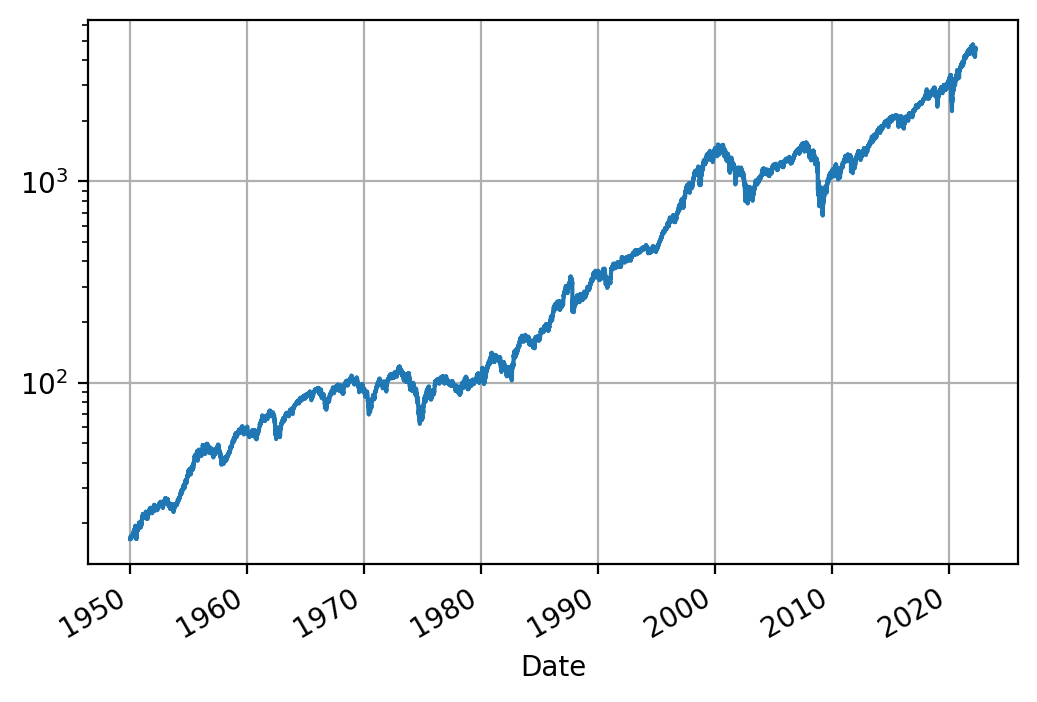

In [7]:
sp500['Adj Close'].plot(grid=True, logy=True);

In [8]:
sp500.loc['2015-02-17', 'Adj Close']

2100.340087890625

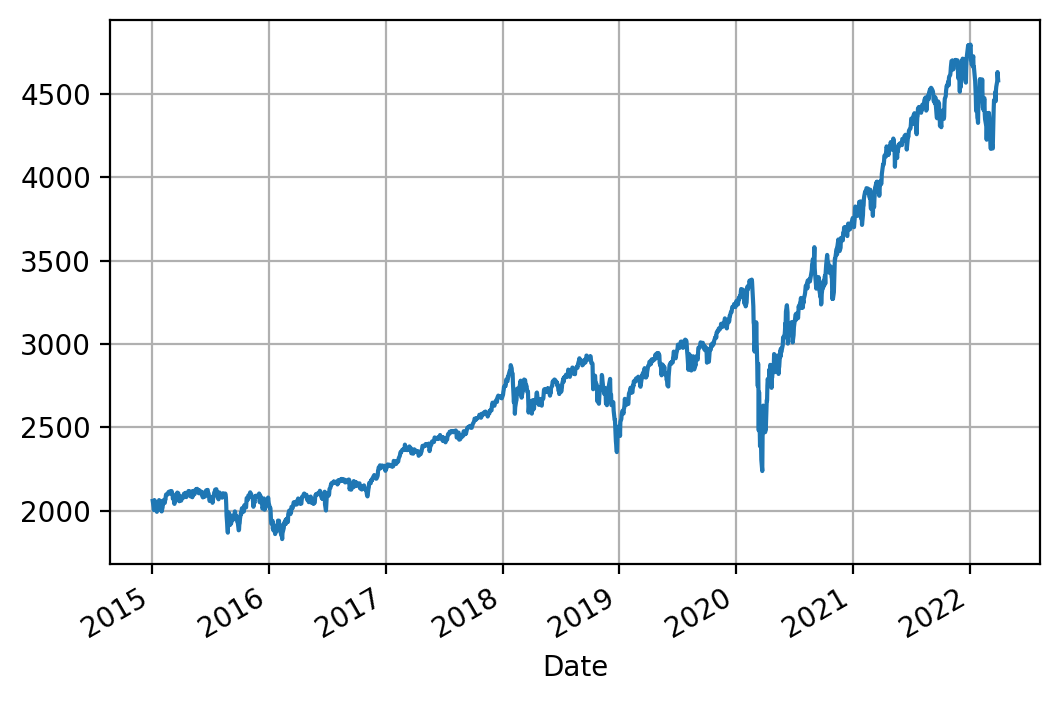

In [9]:
sp500.loc['2015':, 'Adj Close'].plot(grid=True);

# Smooth a time series

The moving average of a time series $y_t$ over window $k$ is calculated as

$$\bar y_t(k) = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i}.$$

In [10]:
sp500['MA30'] = sp500['Adj Close'].rolling(30).mean()
sp500['MA90'] = sp500['Adj Close'].rolling(90).mean()

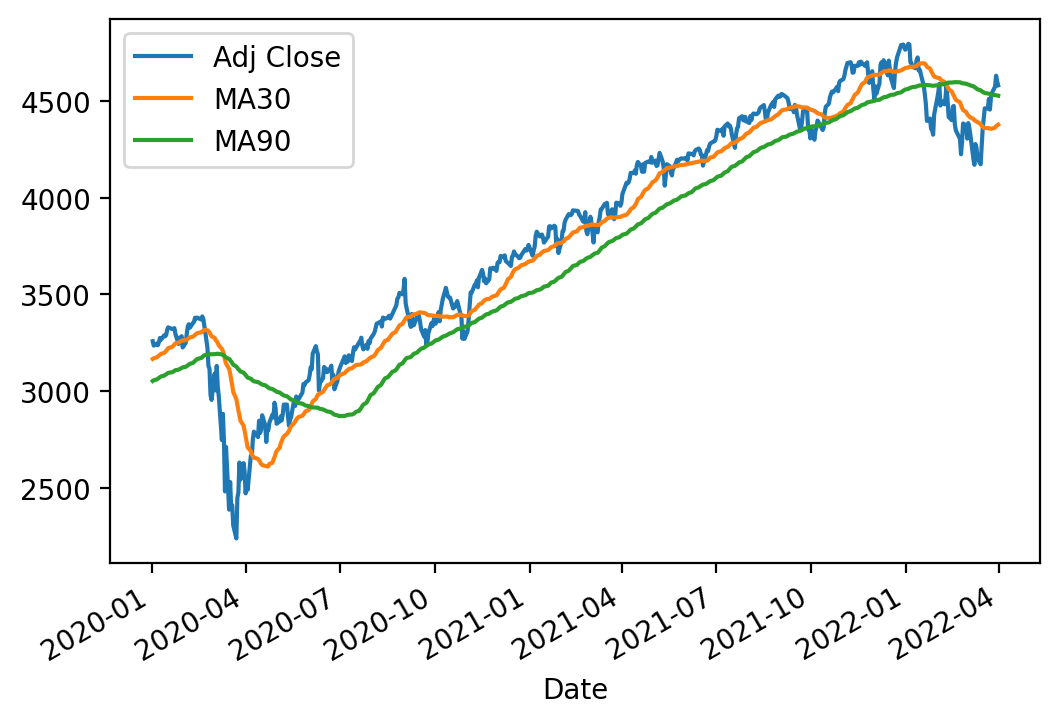

In [11]:
sp500.loc['2020':, ['Adj Close', 'MA30', 'MA90']].plot();

In [12]:
strat = sp500[['Adj Close', 'MA30', 'ret']].copy()

In [13]:
strat = strat.iloc[:-1]

In [14]:
strat = strat.dropna()

In [15]:
strat

,Adj Close,MA30,ret
Date,,,
1950-02-14,17.059999,16.976667,-0.010441
1950-02-15,17.059999,16.990000,0.000000
1950-02-16,16.990000,16.994667,-0.004103
1950-02-17,17.150000,17.002000,0.009417
1950-02-20,17.200001,17.009333,0.002916
...,...,...,...
2022-03-24,4520.160156,4356.440332,0.014344
2022-03-25,4543.060059,4357.739665,0.005066
2022-03-28,4575.520020,4362.968994,0.007145


In [16]:
strat['own'] = 0

In [17]:
strat

,Adj Close,MA30,ret,own
Date,,,,
1950-02-14,17.059999,16.976667,-0.010441,0
1950-02-15,17.059999,16.990000,0.000000,0
1950-02-16,16.990000,16.994667,-0.004103,0
1950-02-17,17.150000,17.002000,0.009417,0
1950-02-20,17.200001,17.009333,0.002916,0
...,...,...,...,...
2022-03-24,4520.160156,4356.440332,0.014344,0
2022-03-25,4543.060059,4357.739665,0.005066,0
2022-03-28,4575.520020,4362.968994,0.007145,0


In [18]:
cond = strat['Adj Close'].shift() > strat['MA30'].shift()

In [19]:
strat.loc[cond, 'own'] = 1

In [20]:
strat['own'].mean()

0.6252341597796143

In [21]:
strat.loc['2018-07-02':'2018-07-11']

,Adj Close,MA30,ret,own
Date,,,,
2018-07-02,2726.709961,2744.236361,0.003068,0
2018-07-03,2713.219971,2743.576693,-0.004947,0
2018-07-05,2736.610107,2743.982365,0.008621,0
2018-07-06,2759.820068,2744.866699,0.008481,0
2018-07-09,2784.169922,2746.747030,0.008823,1
2018-07-10,2793.840088,2749.164030,0.003473,1
2018-07-11,2774.020020,2751.969360,-0.007094,1


In [22]:
strat['strat_ret'] = strat['ret'] * strat['own']

In [23]:
# cumulative returns to each strategy
strat['idx_cret'] = (1+strat['ret']).cumprod() - 1

strat['strat_cret'] = (1+strat['strat_ret']).cumprod() - 1

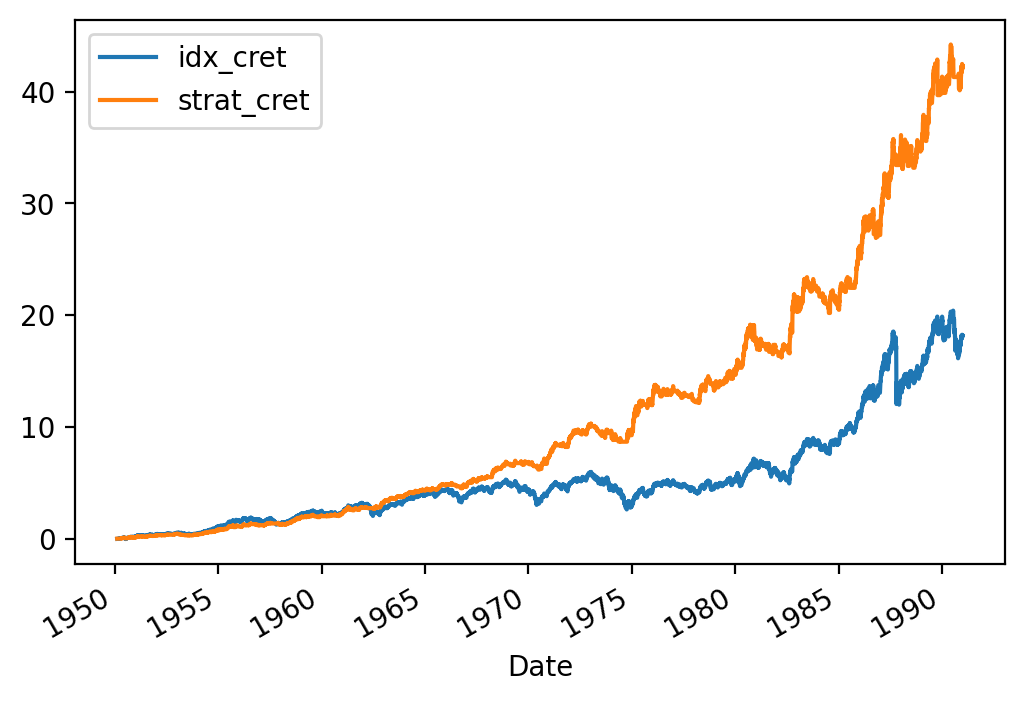

In [24]:
strat.loc[:'1990', ['idx_cret', 'strat_cret']].plot();

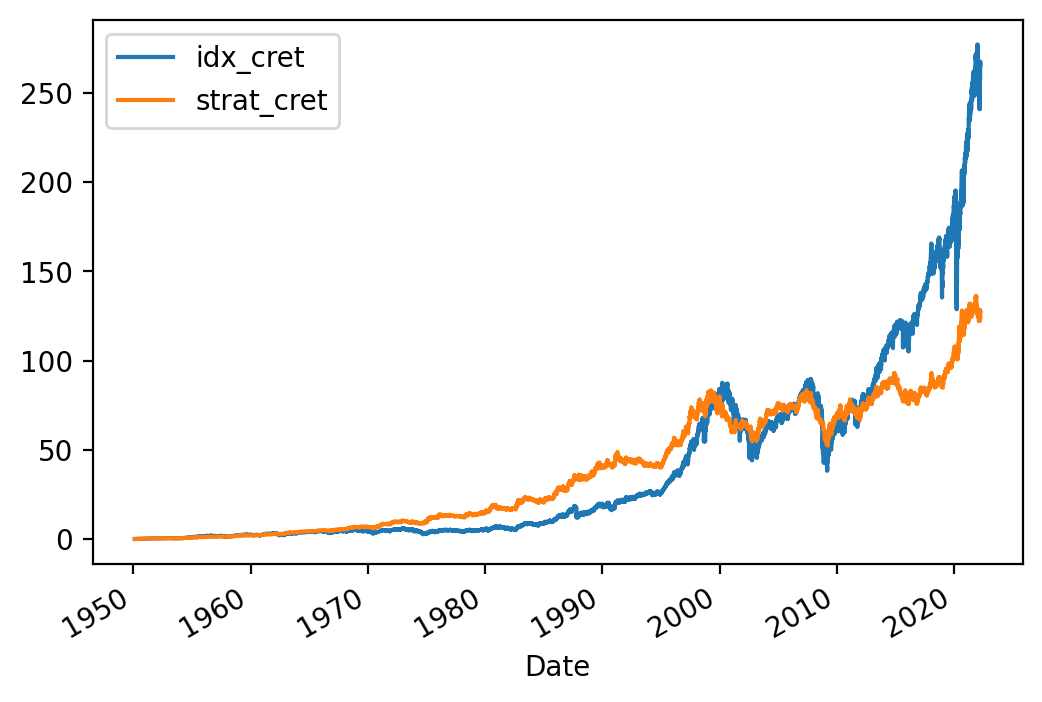

In [25]:
strat.loc[:, ['idx_cret', 'strat_cret']].plot();

In [26]:
def sharpe(x):
  return x.mean() / x.std()

In [27]:
sharpe(strat[['ret', 'strat_ret']])

ret          0.036142
strat_ret    0.046892
dtype: float64

In [28]:
sharpe(strat.loc['1990':, ['ret', 'strat_ret']])

ret          0.033410
strat_ret    0.024111
dtype: float64

# Aggregating daily returns

In [29]:
sp500['Adj Close'].resample('M').last().pct_change()

Date
1950-01-31         NaN
1950-02-28    0.009971
1950-03-31    0.004065
1950-04-30    0.038751
1950-05-31    0.045657
                ...   
2021-11-30   -0.008334
2021-12-31    0.043613
2022-01-31   -0.052585
2022-02-28   -0.031360
2022-03-31    0.047554
Freq: M, Name: Adj Close, Length: 867, dtype: float64

In [30]:
def aggret(ret):
  return (1+ret).product() - 1

In [31]:
aggret(pd.Series([0.03, -0.01, 0.025]))

0.04519249999999997

In [32]:
sp500['ret'].resample('M').agg([aggret, np.std, len])

,aggret,std,len
Date,,,
1950-01-31,0.023409,0.006933,21
1950-02-28,0.009971,0.005037,18
1950-03-31,0.004065,0.004737,23
1950-04-30,0.038751,0.005994,19
1950-05-31,0.045657,0.005476,22
...,...,...,...
2021-11-30,-0.008334,0.008136,21
2021-12-31,0.043613,0.010758,22
2022-01-31,-0.052585,0.011791,20
